# Initialization and choice of the input file

In this domonstration, the user can use this code to segmente and annotate ECG's with any number of leads from MIT format or EDF format. 

Three test files are provided: 
* The file 223.hea is a file from the MIT-BIH original dataset: 2 leads at 360Hz
* The chu01.edf file is a file from the CHU database, recoded by a Bittium recorder using 3 leads.
* The file test01.edf is a one lead file recorded by a wearable prototype provided by our cardiologist partner cardiologist 

In [1]:
# General import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# WFDB of MIT-BIH data handling
import wfdb
# EDF lib of edf reading and writing
import pyedflib
# This class manage to read ECG from different formats
from ECG_Reader import read_file
# A library to write .edf files that can be open with various EDF readers
from ECG_Writer import write
# Our Segmenter
from RDetector import RDetector
# Our Classifier
from BeatClassifier import BeatClassifier

# Path to the file
input_name = '223.hea'
#input_name = 'chu01.edf'
#input_name='test01.edf'
input_file = 'INPUTS/{}'.format(input_name)    # A frile from the MIT-BIH dataset
output_file = 'OUTPUTS/{}.edf'.format(input_name)

# Const:
DEVICE = 'cuda:0'    # Device for computation

# File reading: 
We are using our ECG_Reader.py implementation in order to import the signal. Signal are pre-processed by ou code from the Util.py file and we obtain a matrix who contain on the first dimension the number of leads and the signal duration on the second dimension.

In [2]:
signals = read_file(input_file)

MIT file opening...


# Segmentation:
### 1. Model restoration

In [3]:
segmenter = RDetector().to(DEVICE)
segmenter.restore()

### 2. R-waves Annotation
By using our Segmentation model

In [4]:
annot_sign, annot_idx = segmenter.annot_peaks(signals, device=DEVICE, pre_trait=False)

100%|███████████████████████████████████████████████████████████████████████| 451388/451388 [00:08<00:00, 51581.51it/s]


We can plot a small part of our signal as demo

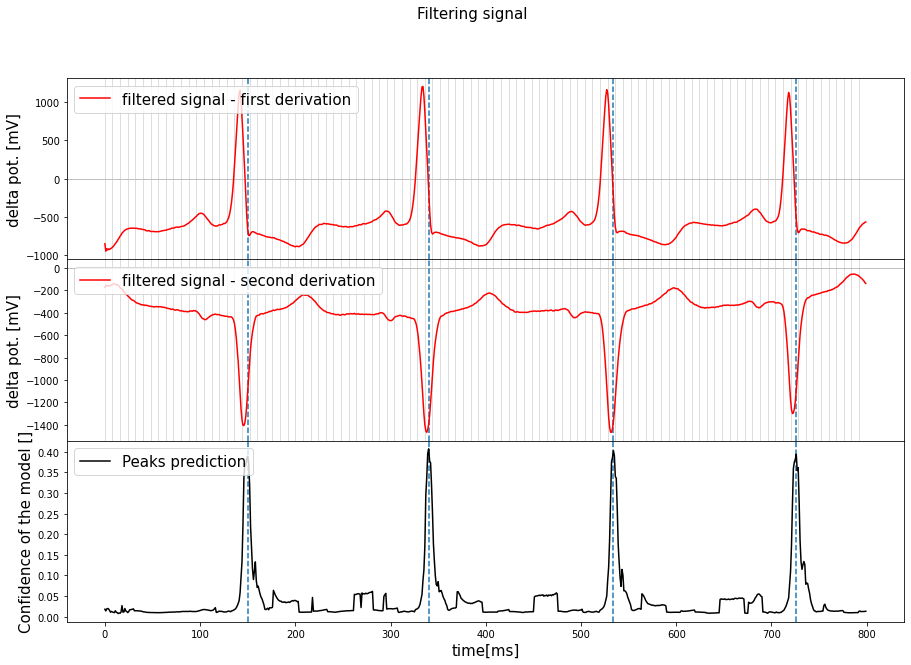

In [5]:
# Index to chose the part of the signal:
s_ = 0
e_ = 800

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, hspace=0)
ax1, ax2, ax3 = gs.subplots()
i_ = np.arange(-1, 1, 0.025)

for i in i_:
    ax1.axhline(y=i, color='silver', linewidth=0.75, alpha=0.7)
    ax2.axhline(y=i, color='silver', linewidth=0.75, alpha=0.7)
i_ = np.arange(s_, e_, (e_-s_)/100)
for i in i_:
    ax1.axvline(x=i, color='silver', linewidth=0.75, alpha=0.7)
    ax2.axvline(x=i, color='silver', linewidth=0.75, alpha=0.7)
for itm in annot_idx:
    if s_ < itm < e_:
        ax1.axvline(x=itm, color="tab:blue", linewidth=1.5, linestyle='--')
        ax2.axvline(x=itm, color="tab:blue", linewidth=1.5, linestyle='--')
        ax3.axvline(x=itm, color="tab:blue", linewidth=1.5, linestyle='--')

ax1.plot([i for i in range(s_, e_)], signals[0][s_:e_], label='filtered signal - first derivation', color='red')
ax2.plot([i for i in range(s_, e_)], signals[1][s_:e_], label='filtered signal - second derivation', color='red')
ax3.plot([i for i in range(s_, e_)], annot_sign[s_:e_], label='Peaks prediction', color='black')
fig.suptitle("Filtering signal", fontsize=15)
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper left', fontsize=15)
ax3.legend(loc='upper left', fontsize=15)
ax1.set_ylabel("delta pot. [mV]", fontsize=15)
ax2.set_ylabel("delta pot. [mV]", fontsize=15)
ax3.set_ylabel("Confidence of the model []", fontsize=15)
ax3.set_xlabel("time[ms]", fontsize=15)
plt.show()
plt.close()

# Beat Annotation
### 1. Model restoration

In [6]:
classifier = BeatClassifier(name='Classifier', device=DEVICE).to(DEVICE)
classifier.restore()

### 2. Annot each R waves with the class of the beat

In [7]:
annot_class, _ = classifier.annot(signals, annot_idx, batch_size=200)

### 3. Export the file to an EDF file
This format can be easily open by various online and offline .edf readers like the open-source software EDF-Browser

If the parameter annot_sign is given to the function, the R-detector confidence signal, multiply by 500 is export as an ECG lead.

During this the R-detector processing, the limit treshodl for peaks annotation is set on 0.1

In [8]:
write(signals, annot_class, annot_idx, output_file, annot_sign=annot_sign)

OUTPUTS/223.hea.edf successfully exported to EDF file format


### 4. Output annotated files can be open by using EDF-Browser:

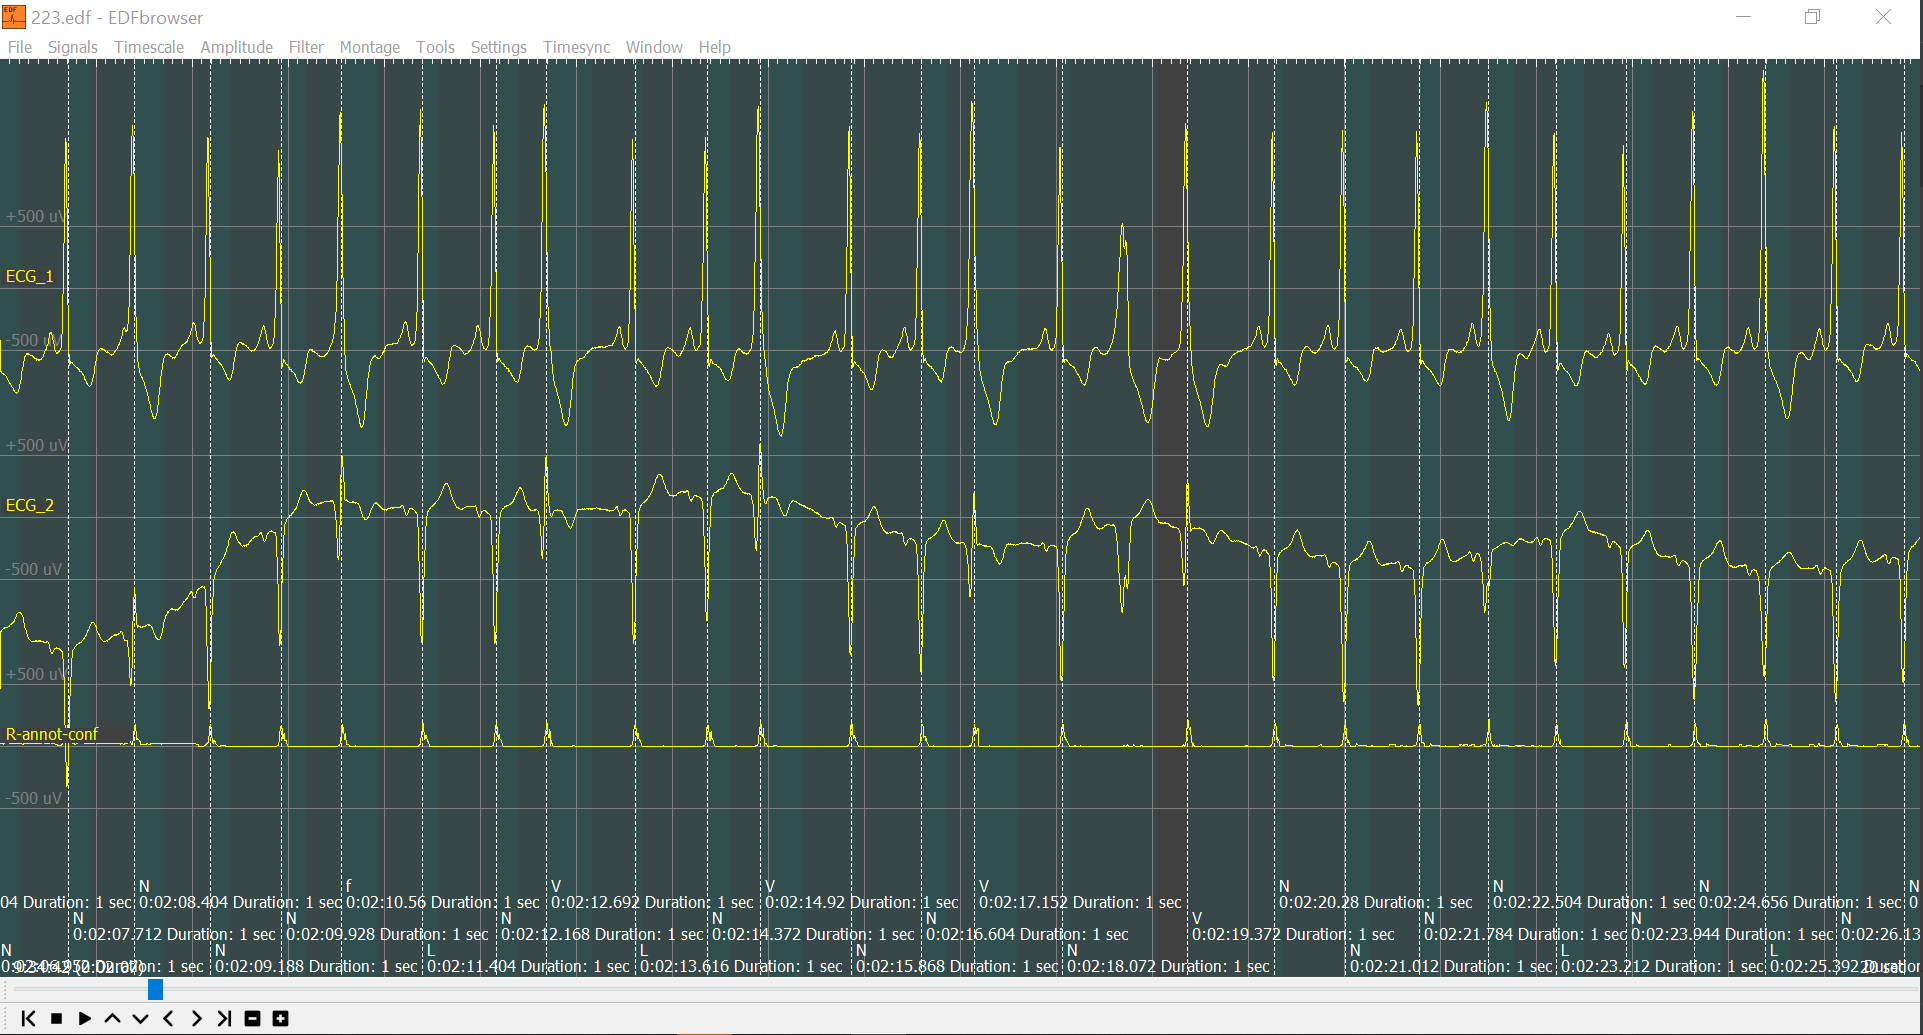

